# Description

The notebooks performs comparison between bid-ask data loaded from `"v1_0_0"`and `"v2_0_0"` data versions.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.ccxt.data.client as icdcl
import im_v2.common.universe as ivcu
import market_data.market_data_example as mdmadaex

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-ba3040c2-d5eb-49dd-9337-2eec70ab7f0b.json'
INFO  # Git
  branch_name='CmTask8256_Analyse_diff_between_v1_0_0_and_v2_0_0_bid_ask_data'
  hash='068cce59e'
  # Last commits:
    *   068cce59e Dan      Merge branch 'master' into CmTask8256_Analyse_diff_between_v1_0_0_and_v2_0_0_bid_ask_data ( 6 minutes ago) Tue May 21 13:18:01 2024  (HEAD -> CmTask8256_Analyse_diff_between_v1_0_0_and_v2_0_0_bid_ask_data, origin/CmTask8256_Analyse_diff_between_v1_0_0_and_v2_0_0_bid_ask_data)
    |\  
    | * 778188995 Vlad     CmampTask8340_GitHub_actions_and_bashing_into_docker_container_is_failing (#8343) (   3 hours ago) Tue May 21 10:31:19 2024  (origin/master, origin/HEAD, origin/CmTask8123_Optimize_bid_ask_execution_notebook, master)
    * | 5c7511982 Dan      Merge branch 'master' into CmTask8256_Analyse_diff_between_v1_0_0_and_v2_0_0_bid_ask_data (  24 hours ago) Mon May 20 13:38:45 2024

# Config

In [4]:
universe_version = "v8.1"
wall_clock_time = pd.Timestamp("2100-01-01T00:00:00+00:00")
config = {
    "universe": {
        "vendor": "CCXT",
        "mode": "trade",
        "version": universe_version,
        "as_full_symbol": True,
    },
    "US_equities_tz": "America/New_York",
    "bid_ask_data": {
        "start_timestamp": pd.Timestamp("2024-01-23T00:00:00+00:00"),
        "end_timestamp": pd.Timestamp("2024-02-01T23:59:00+00:00"),
        "column_names": {
            "timestamp": "timestamp",
        },
        "im_client_config_v1": {
            "universe_version": "v8",
            "root_dir": "s3://cryptokaizen-data-test/v3",
            "partition_mode": "by_year_month",
            "dataset": "bid_ask",
            "contract_type": "futures",
            "data_snapshot": "",
            "version": "v1_0_0",
            "download_universe_version": "v8",
            "tag": "resampled_1min",
            "aws_profile": "ck",
        },
        "market_data_config_v1": {
            "columns": [
                "level_1.bid_price.open",
                "level_1.bid_price.high",
                "level_1.bid_price.low",
                "level_1.bid_price.close",
                "level_1.bid_price.mean",
                "level_1.bid_size.open",
                "level_1.bid_size.max",
                "level_1.bid_size.min",
                "level_1.bid_size.close",
                "level_1.bid_size.mean",
                "level_1.ask_price.open",
                "level_1.ask_price.high",
                "level_1.ask_price.low",
                "level_1.ask_price.close",
                "level_1.ask_price.mean",
                "level_1.ask_size.open",
                "level_1.ask_size.max",
                "level_1.ask_size.min",
                "level_1.ask_size.close",
                "level_1.ask_size.mean",
                "asset_id",
                "full_symbol",
                "start_ts",
                "knowledge_timestamp",
            ],
            "column_remap": None,
            "wall_clock_time": wall_clock_time,
            "filter_data_mode": "assert",
        },
        "im_client_config_v2": {
            "universe_version": "v8",
            "root_dir": "s3://cryptokaizen-data-test/v3",
            "partition_mode": "by_year_month",
            "dataset": "bid_ask",
            "contract_type": "futures",
            "data_snapshot": "",
            "version": "v2_0_0",
            "download_universe_version": "v8",
            "tag": "resampled_1min",
            "aws_profile": "ck",
        },
        "market_data_config_v2": {
            "columns": cofinanc.get_bid_ask_columns_by_level(1)
            + ["asset_id", "full_symbol", "start_ts", "knowledge_timestamp"],
            "column_remap": None,
            "wall_clock_time": wall_clock_time,
            "filter_data_mode": "assert",
        },
        "column_names": {
            "timestamp": "timestamp",
            "full_symbol": "full_symbol",
            "close": "close",
            "volume": "volume",
            "volume_notional": "volume_notional",
            "ask_price": "level_1.ask_price.close",
            "bid_price": "level_1.bid_price.close",
        },
    },
}
config = cconfig.Config().from_dict(config)
print(config)

universe: 
  vendor: CCXT
  mode: trade
  version: v8.1
  as_full_symbol: True
US_equities_tz: America/New_York
bid_ask_data: 
  start_timestamp: 2024-01-23 00:00:00+00:00
  end_timestamp: 2024-02-01 23:59:00+00:00
  column_names: 
    timestamp: timestamp
    full_symbol: full_symbol
    close: close
    volume: volume
    volume_notional: volume_notional
    ask_price: level_1.ask_price.close
    bid_price: level_1.bid_price.close
  im_client_config_v1: 
    universe_version: v8
    root_dir: s3://cryptokaizen-data-test/v3
    partition_mode: by_year_month
    dataset: bid_ask
    contract_type: futures
    data_snapshot: 
    version: v1_0_0
    download_universe_version: v8
    tag: resampled_1min
    aws_profile: ck
  market_data_config_v1: 
    columns: ['level_1.bid_price.open', 'level_1.bid_price.high', 'level_1.bid_price.low', 'level_1.bid_price.close', 'level_1.bid_price.mean', 'level_1.bid_size.open', 'level_1.bid_size.max', 'level_1.bid_size.min', 'level_1.bid_size.close', 

# Universe

In [5]:
# Get full symbol universe.
full_symbols = ivcu.get_vendor_universe(**config["universe"])
_LOG.info("The number of coins in the universe=%s", len(full_symbols))
full_symbols

INFO  The number of coins in the universe=25


['binance::1000LUNC_USDT',
 'binance::API3_USDT',
 'binance::ARB_USDT',
 'binance::AVAX_USDT',
 'binance::BCH_USDT',
 'binance::BNB_USDT',
 'binance::ENS_USDT',
 'binance::ETC_USDT',
 'binance::GRT_USDT',
 'binance::ICP_USDT',
 'binance::IMX_USDT',
 'binance::INJ_USDT',
 'binance::LDO_USDT',
 'binance::LINK_USDT',
 'binance::MINA_USDT',
 'binance::MKR_USDT',
 'binance::OP_USDT',
 'binance::PENDLE_USDT',
 'binance::RNDR_USDT',
 'binance::SOL_USDT',
 'binance::STX_USDT',
 'binance::SUI_USDT',
 'binance::TRB_USDT',
 'binance::WLD_USDT',
 'binance::XMR_USDT']

In [6]:
# Get asset ids.
asset_ids = [
    ivcu.string_to_numerical_id(full_symbol) for full_symbol in full_symbols
]
asset_ids

[2499295598,
 2971863517,
 5141755262,
 8717633868,
 3304664847,
 8968126878,
 1670436375,
 3323452427,
 1813442534,
 6335759645,
 1106736216,
 2506553600,
 4417972573,
 2601760471,
 1775391824,
 1871387621,
 1020313424,
 2989693852,
 1669260535,
 2237530510,
 2565005155,
 3326458212,
 2200033667,
 6009830573,
 2470395105]

# Bid / ask price changes

## `"v1_0_0"`

In [7]:
bid_ask_im_client_v1 = icdcl.ccxt_clients.CcxtHistoricalPqByTileClient(
    **config["bid_ask_data"]["im_client_config_v1"]
)

In [8]:
bid_ask_market_data_v1 = mdmadaex.get_HistoricalImClientMarketData_example1(
    bid_ask_im_client_v1,
    asset_ids,
    **config["bid_ask_data"]["market_data_config_v1"],
)

In [9]:
bid_ask_data_v1 = bid_ask_market_data_v1.get_data_for_interval(
    config["bid_ask_data"]["start_timestamp"],
    config["bid_ask_data"]["end_timestamp"],
    config["bid_ask_data"]["column_names"]["timestamp"],
    asset_ids,
)
# Convert to ET to be able to compare with US equities active trading hours.
bid_ask_data_v1.index = bid_ask_data_v1.index.tz_convert(config["US_equities_tz"])
hpandas.df_to_str(bid_ask_data_v1, num_rows=5, log_level=logging.INFO)

,asset_id,full_symbol,level_1.bid_price.open,level_1.bid_price.high,level_1.bid_price.low,level_1.bid_price.close,level_1.bid_price.mean,level_1.bid_size.open,level_1.bid_size.max,level_1.bid_size.min,level_1.bid_size.close,level_1.bid_size.mean,level_1.ask_price.open,level_1.ask_price.high,level_1.ask_price.low,level_1.ask_price.close,level_1.ask_price.mean,level_1.ask_size.open,level_1.ask_size.max,level_1.ask_size.min,level_1.ask_size.close,level_1.ask_size.mean,knowledge_timestamp,start_ts
2024-01-23 12:52:00-05:00,1020313424,binance::OP_USDT,2.7134,2.7136,2.7034,2.7097,2.70926,209.5,2029.8,2.1,442.7,354.892308,2.7135,2.7137,2.7035,2.7098,2.709383,230.9,2973.6,1.3,8.8,334.619658,2024-01-26 16:34:54.064663+00:00,2024-01-23 12:51:00-05:00
2024-01-23 12:52:00-05:00,1106736216,binance::IMX_USDT,1.7975,1.7975,1.7932,1.7961,1.795658,4.0,629.0,3.0,9.0,64.241071,1.798,1.798,1.7935,1.7965,1.795908,15.0,409.0,3.0,84.0,66.6875,2024-01-26 16:34:54.064663+00:00,2024-01-23 12:51:00-05:00
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01 18:58:00-05:00,8717633868,binance::AVAX_USDT,33.793,33.813,33.793,33.804,33.803698,23.0,268.0,3.0,75.0,101.952663,33.794,33.814,33.794,33.805,33.804698,4.0,195.0,1.0,3.0,64.272189,2024-02-02 15:26:48.805547+00:00,2024-02-01 18:57:00-05:00
2024-02-01 18:58:00-05:00,8968126878,binance::BNB_USDT,300.1,300.13,300.08,300.13,300.111871,9.56,97.48,2.79,17.47,22.081287,300.11,300.14,300.09,300.14,300.121871,57.48,144.04,1.66,40.18,71.292924,2024-02-02 15:26:48.805547+00:00,2024-02-01 18:57:00-05:00


## `"v2_0_0"`

In [10]:
bid_ask_im_client_v2 = icdcl.ccxt_clients.CcxtHistoricalPqByTileClient(
    **config["bid_ask_data"]["im_client_config_v2"]
)

In [11]:
bid_ask_market_data_v2 = mdmadaex.get_HistoricalImClientMarketData_example1(
    bid_ask_im_client_v2,
    asset_ids,
    **config["bid_ask_data"]["market_data_config_v2"],
)

In [12]:
bid_ask_data_v2 = bid_ask_market_data_v2.get_data_for_interval(
    config["bid_ask_data"]["start_timestamp"],
    config["bid_ask_data"]["end_timestamp"],
    config["bid_ask_data"]["column_names"]["timestamp"],
    asset_ids,
)
# Convert to ET to be able to compare with US equities active trading hours.
bid_ask_data_v2.index = bid_ask_data_v2.index.tz_convert(config["US_equities_tz"])
hpandas.df_to_str(bid_ask_data_v2, num_rows=5, log_level=logging.INFO)

,asset_id,full_symbol,level_1.bid_price.open,level_1.bid_price.high,level_1.bid_price.low,level_1.bid_price.close,level_1.bid_price.mean,level_1.bid_size.open,level_1.bid_size.max,level_1.bid_size.min,level_1.bid_size.close,level_1.bid_size.mean,level_1.ask_price.open,level_1.ask_price.high,level_1.ask_price.low,level_1.ask_price.close,level_1.ask_price.mean,level_1.ask_size.open,level_1.ask_size.max,level_1.ask_size.min,level_1.ask_size.close,level_1.ask_size.mean,level_1.bid_ask_midpoint.open,level_1.bid_ask_midpoint.max,level_1.bid_ask_midpoint.min,level_1.bid_ask_midpoint.close,level_1.bid_ask_midpoint.mean,level_1.bid_ask_midpoint_var.100ms,level_1.bid_ask_midpoint_autocovar.100ms,level_1.log_size_imbalance.open,level_1.log_size_imbalance.max,level_1.log_size_imbalance.min,level_1.log_size_imbalance.close,level_1.log_size_imbalance.mean,level_1.log_size_imbalance_var.100ms,level_1.log_size_imbalance_autocovar.100ms,level_1.half_spread.open,level_1.half_spread.max,level_1.half_spread.min,level_1.half_spread.close,level_1.half_spread.mean,knowledge_timestamp,start_ts
2024-01-30 19:01:00-05:00,1020313424,binance::OP_USDT,3.156,3.1599,3.1521,3.156,3.156452,225.9,3739.7,0.1,192.1,478.502333,3.1561,3.16,3.1522,3.1561,3.156575,2.2,4203.6,0.1,1012.4,466.9945,3.15605,3.15995,3.15215,3.15605,3.156514,0.000023,0.0,4.631635,9.664786,-8.822027,-1.662063,0.321247,4763.319254,3923.661872,0.00005,0.00045,0.00005,0.00005,0.000061,2024-03-09 18:59:14.310863+00:00,2024-01-30 19:00:00-05:00
2024-01-30 19:01:00-05:00,1106736216,binance::IMX_USDT,2.0056,2.009,2.0055,2.0078,2.0079,22.0,4330.0,1.0,7.0,296.246667,2.0059,2.0091,2.0058,2.008,2.008139,92.0,793.0,4.0,62.0,106.768333,2.00575,2.00905,2.0057,2.0079,2.008019,0.000005,0.0,-1.430746,4.549657,-5.32301,-2.181224,-0.426465,1993.84625,1701.107548,0.00015,0.00035,0.00005,0.0001,0.00012,2024-03-09 18:59:14.310863+00:00,2024-01-30 19:00:00-05:00
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01 18:58:00-05:00,8717633868,binance::AVAX_USDT,33.793,33.813,33.793,33.804,33.80312,23.0,268.0,3.0,75.0,96.5,33.794,33.814,33.794,33.805,33.80412,4.0,195.0,1.0,3.0,65.321667,33.7935,33.8135,33.7935,33.8045,33.80362,0.000327,0.0,1.7492,4.49981,-3.628776,3.218876,0.528192,1503.908185,1438.33731,0.0005,0.0005,0.0005,0.0005,0.0005,2024-03-09 19:33:01.682871+00:00,2024-02-01 18:57:00-05:00
2024-02-01 18:58:00-05:00,8968126878,binance::BNB_USDT,300.1,300.13,300.08,300.13,300.110583,9.56,97.48,2.79,17.47,21.813667,300.11,300.14,300.09,300.14,300.120583,57.48,144.04,1.66,40.18,73.298317,300.105,300.135,300.085,300.135,300.115583,0.0013,0.0,-1.793849,2.95139,-3.786143,-0.832884,-1.149556,1564.546319,1544.712731,0.005,0.005,0.005,0.005,0.005,2024-03-09 19:33:01.682871+00:00,2024-02-01 18:57:00-05:00


## Compare data

In [13]:
cols_to_drop = ["full_symbol", "knowledge_timestamp", "start_ts"]

In [14]:
bid_ask_data_v1_0_0 = bid_ask_data_v1.drop(cols_to_drop, axis=1).pivot(
    columns="asset_id"
)
bid_ask_data_v2_0_0 = bid_ask_data_v2.drop(cols_to_drop, axis=1).pivot(
    columns="asset_id"
)

In [15]:
diff_df_pct = hpandas.compare_dfs(
    bid_ask_data_v1_0_0,
    bid_ask_data_v2_0_0,
    row_mode="inner",
    column_mode="inner",
    diff_mode="pct_change",
    assert_diff_threshold=0.0001,
)
hpandas.df_to_str(diff_df_pct, num_rows=5, log_level=logging.INFO)

WARNING * Failed assertion *
'0'
==
'3'
There are NaN values in one of the dataframes that are not in the other one.
Continuing as per user request with only_warning=True
WARNING * Failed assertion *
DataFrame.iloc[:, 25] (column name="('level_1.ask_price.high', 1020313424)") are different

DataFrame.iloc[:, 25] (column name="('level_1.ask_price.high', 1020313424)") values are different (1.8763 %)
[index]: [2024-01-30 19:01:00-05:00, 2024-01-30 19:02:00-05:00, 2024-01-30 19:03:00-05:00, 2024-01-30 19:04:00-05:00, 2024-01-30 19:05:00-05:00, 2024-01-30 19:06:00-05:00, 2024-01-30 19:07:00-05:00, 2024-01-30 19:08:00-05:00, 2024-01-30 19:09:00-05:00, 2024-01-30 19:10:00-05:00, 2024-01-30 19:11:00-05:00, 2024-01-30 19:12:00-05:00, 2024-01-30 19:13:00-05:00, 2024-01-30 19:14:00-05:00, 2024-01-30 19:15:00-05:00, 2024-01-30 19:16:00-05:00, 2024-01-30 19:17:00-05:00, 2024-01-30 19:18:00-05:00, 2024-01-30 19:19:00-05:00, 2024-01-30 19:20:00-05:00, 2024-01-30 19:21:00-05:00, 2024-01-30 19:22:00-05

level_1.ask_price.close.pct_change                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 level_1.ask_price.high.pct_change                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 level_1.ask_price.low.pct_change                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 level_1.ask_price.mean.pct_change                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 level_1.ask_price.open.pct_change                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 level_1.ask_size.close.pct_change                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 level_1.ask_size.max.pct_change                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 level_1.ask_size.mean.pct_change                                    

level_1.ask_price.close.pct_change     0.000000
level_1.ask_price.high.pct_change      0.818624
level_1.ask_price.low.pct_change       0.717165
level_1.ask_price.mean.pct_change      0.683808
level_1.ask_price.open.pct_change      9.476025
level_1.ask_size.close.pct_change      0.000000
level_1.ask_size.max.pct_change        0.511466
level_1.ask_size.mean.pct_change      99.553857
level_1.ask_size.min.pct_change        0.283530
level_1.ask_size.open.pct_change      38.161223
level_1.bid_price.close.pct_change     0.000000
level_1.bid_price.high.pct_change      0.843641
level_1.bid_price.low.pct_change       0.701876
level_1.bid_price.mean.pct_change      0.694927
level_1.bid_price.open.pct_change      9.498263
level_1.bid_size.close.pct_change      0.000000
level_1.bid_size.max.pct_change        0.498958
level_1.bid_size.mean.pct_change      99.567755
level_1.bid_size.min.pct_change        0.262682
level_1.bid_size.open.pct_change      38.076442
dtype: float64

<Axes: >

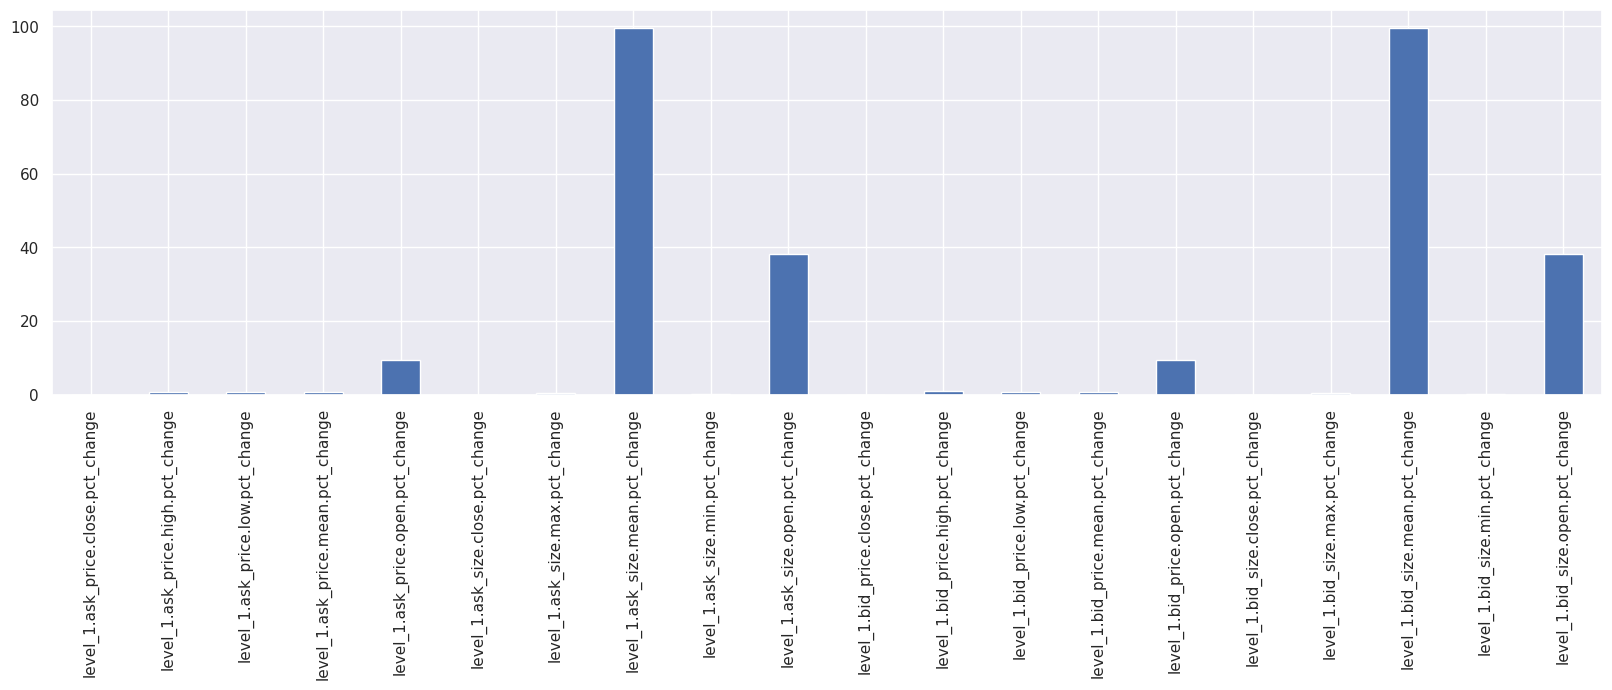

In [23]:
diff_stats_per_column = (
    100
    * diff_df_pct[abs(diff_df_pct) > 0.01].count().groupby(level=[0]).mean()
    / len(diff_df_pct)
)
display(diff_stats_per_column)
diff_stats_per_column.plot(kind="bar")

asset_id
1020313424.pct_change    15.905142
1106736216.pct_change    14.091383
1669260535.pct_change    14.706393
1670436375.pct_change    15.368311
1775391824.pct_change    14.426685
1813442534.pct_change    13.763030
1871387621.pct_change    13.083739
2200033667.pct_change    14.906185
2237530510.pct_change    17.164698
2470395105.pct_change    13.380820
2499295598.pct_change    14.551772
2506553600.pct_change    15.571577
2565005155.pct_change    15.012161
2601760471.pct_change    16.367269
2971863517.pct_change    15.399583
2989693852.pct_change    14.711605
3304664847.pct_change    14.032314
3323452427.pct_change    16.395066
3326458212.pct_change    17.213343
4417972573.pct_change    13.558026
5141755262.pct_change    15.611536
6009830573.pct_change    14.437109
6335759645.pct_change    14.160876
8717633868.pct_change    16.148367
8968126878.pct_change    15.470813
dtype: float64

<Axes: xlabel='asset_id'>

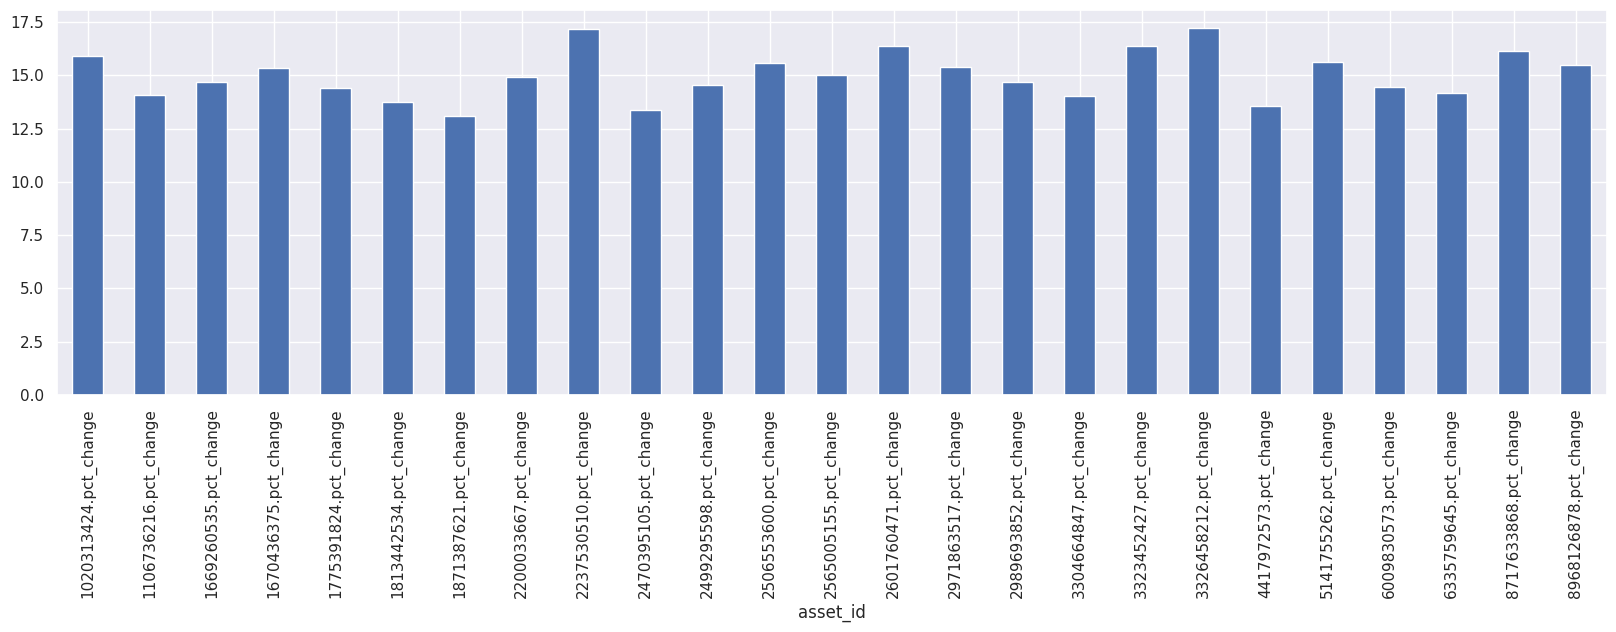

In [25]:
diff_stats_per_asset = (
    100
    * diff_df_pct[abs(diff_df_pct) > 0.01].count().groupby(level=[1]).mean()
    / len(diff_df_pct)
)
display(diff_stats_per_asset)
diff_stats_per_asset.plot(kind="bar")